In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
from IPython import display
from IPython.display import clear_output
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
from time import time
# from helpers import *
from LDMIBSS import *
%load_ext autoreload
%autoreload 2

The following is the correlation matrix of sources


<IPython.core.display.Math object>

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 29.99673825673372


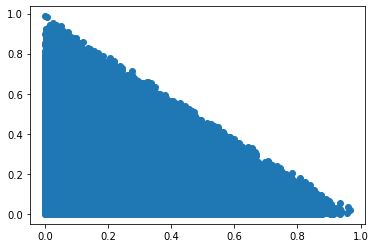

In [3]:
N = 500000
NumberofSources = 5
NumberofMixtures = 10

S = np.random.exponential(scale=1.0, size=(NumberofSources,int(N)))
S = S / np.sum(S, axis = 0)
print("The following is the correlation matrix of sources")
display_matrix(np.corrcoef(S))
plt.scatter(S[0,:], S[1,:])

# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

SNR = 30
X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

In [4]:
s_dim = S.shape[0]
x_dim = X.shape[0]
debug_iteration_point = 100
model = BatchLDMIBSS(s_dim = s_dim, x_dim = x_dim,
                     set_ground_truth = True, S = S, A = A)

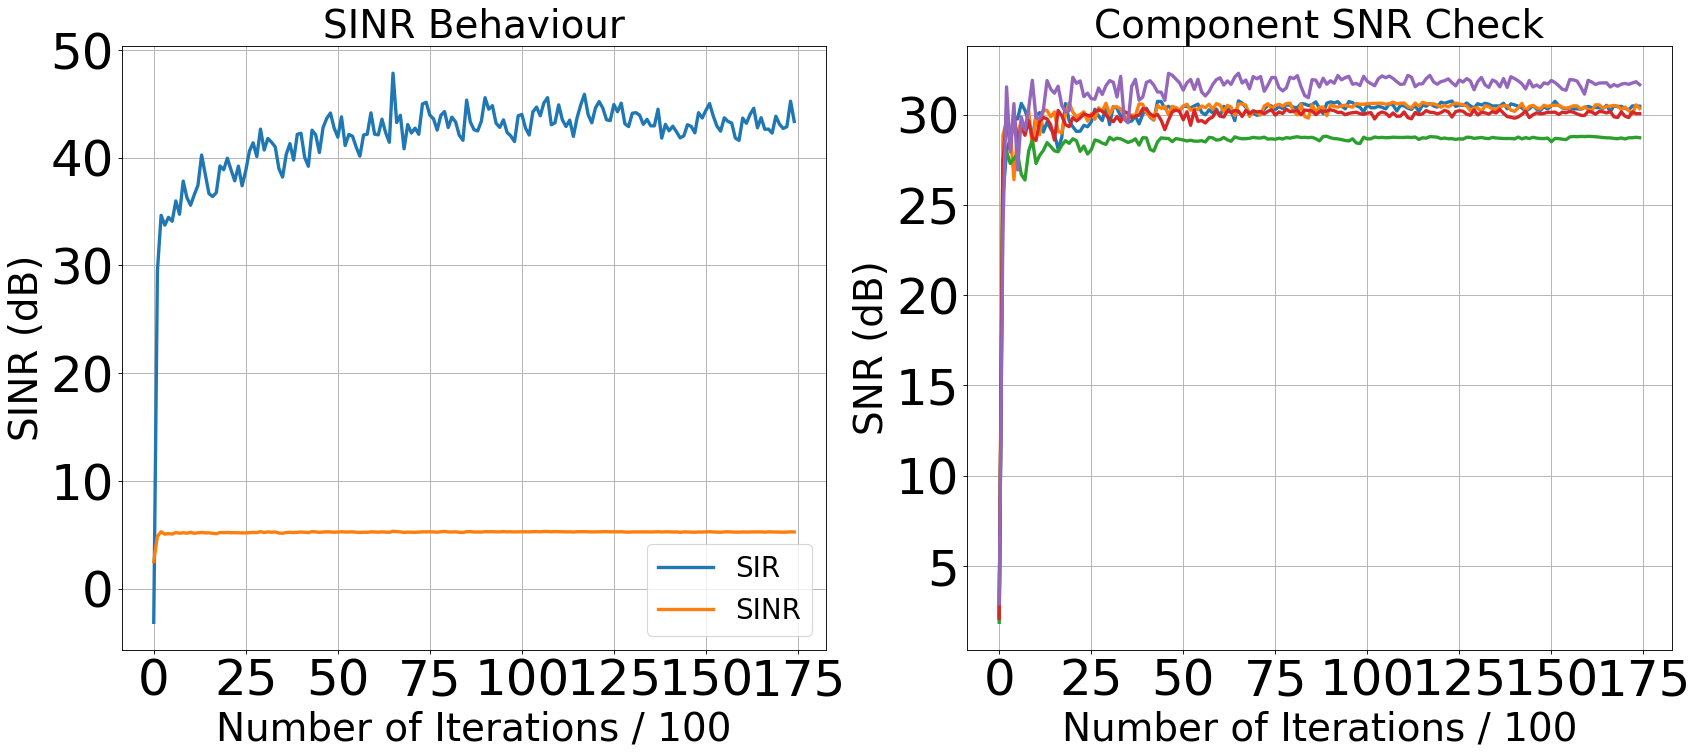

100%|██████████| 600/600 [00:13<00:00, 43.33it/s]


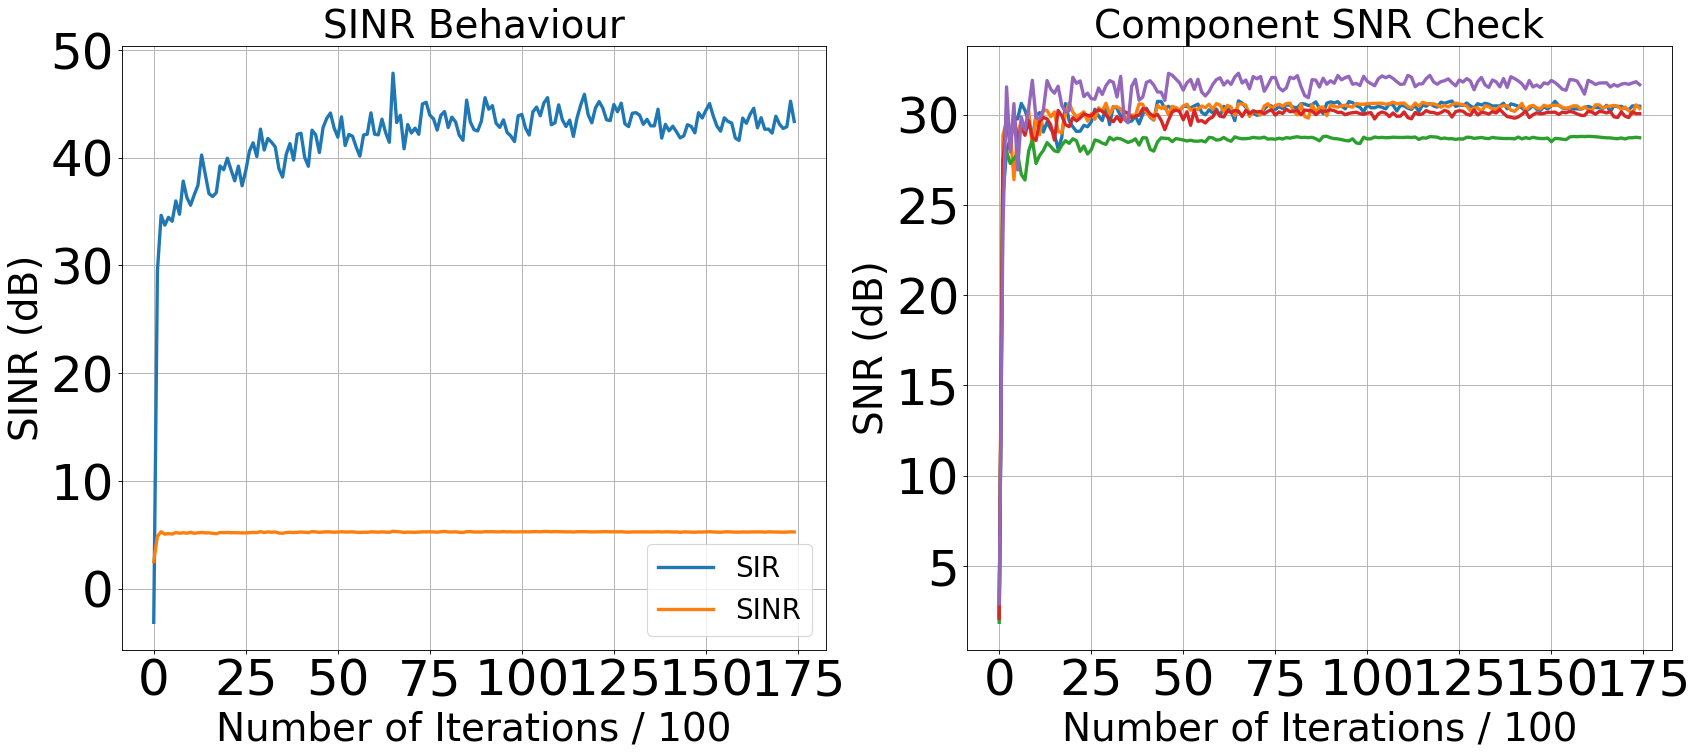

In [5]:
model.fit_batch_simplex(X, batch_size = 20000, epsilon = 1e-5, mu_start = 200, 
                        n_iterations_per_batch = 600, method = "covariance", 
                        debug_iteration_point = debug_iteration_point,
                        plot_in_jupyter = True)

In [6]:
W = model.W
Y = W @ X
10 * np.log10(CalculateSINR(Y, S)[0])

5.2564945189693

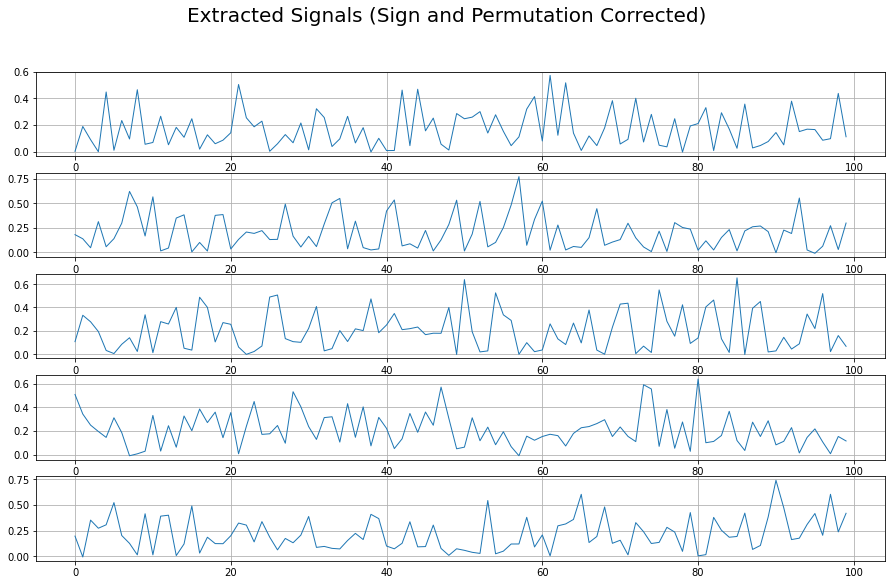

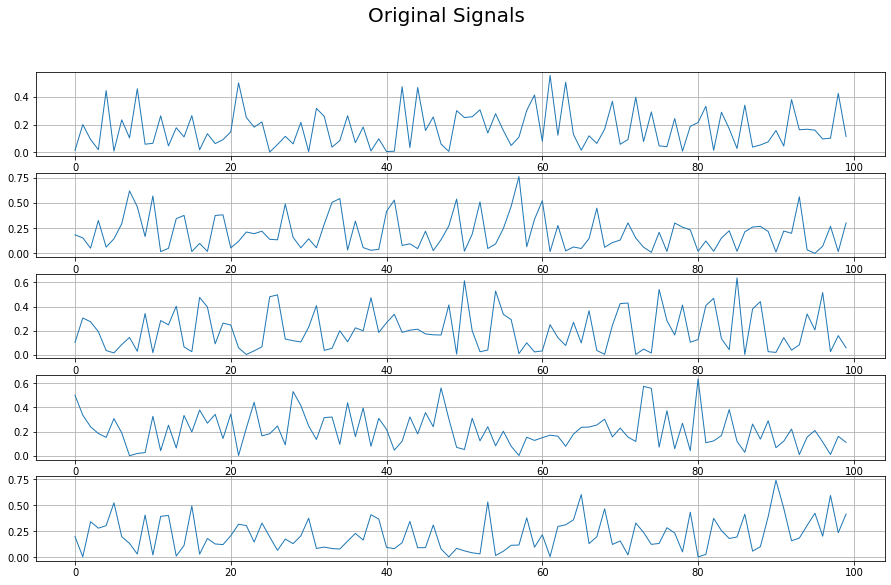

In [7]:
Y = W @ X
Y_ = signed_and_permutation_corrected_sources(S.T,Y.T).T
subplot_1D_signals(X = Y_.T[0:100], title = 'Extracted Signals (Sign and Permutation Corrected)' ,figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X = S.T[0:100], title = 'Original Signals' ,figsize = (15.2,9), colorcode = None)

In [8]:
Out = W @ X
r=S.shape[0]
G=np.dot(Out-np.reshape(np.mean(Out,1),(r,1)),np.linalg.pinv(S-np.reshape(np.mean(S,1),(r,1))))
indmax=np.argmax(np.abs(G),1)
indmax = find_permutation_between_source_and_estimation(Y.T, S.T)
GG=np.zeros((r,r))
for kk in range(r):
    GG[kk,indmax[kk]]=np.dot(Out[kk,:]-np.mean(Out[kk,:]),S[indmax[kk],:].T-np.mean(S[indmax[kk],:]))/np.dot(S[indmax[kk],:]-np.mean(S[indmax[kk],:]),S[indmax[kk],:].T-np.mean(S[indmax[kk],:]))#(G[kk,indmax[kk]])
ZZ=GG@(S-np.reshape(np.mean(S,1),(r,1)))+np.reshape(np.mean(Out,1),(r,1))
E=Out-ZZ
MSE=np.linalg.norm(E,'fro')**2
SigPow=np.linalg.norm(ZZ,'fro')**2
SINR=(SigPow/MSE)

In [9]:
10*np.log10(SINR)

30.389696799443282

In [10]:
indmax

array([3, 1, 4, 2, 0])

In [11]:
np.mod(find_permutation_between_source_and_estimation(Y.T, S.T),5)

array([3, 1, 4, 2, 0])